In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'times'
from matplotlib import cm
import sympy
import re
import diffrax

from algorithms.genetic_programming import GeneticProgramming

from environments.harmonic_oscillator import HarmonicOscillator
from environments.reactor import StirredTankReactor
from environments.acrobot import Acrobot, Acrobot2

import evaluators.dynamic_evaluate as dynamic_evaluate
import evaluators.static_evaluate as static_evaluate
import evaluators.lqg_evaluate as lqg_evaluate
import evaluators.cma_es_evaluator as cma_evaluate

import genetic_operators.simplification as simplification

from miscellaneous.expression import Expression
from miscellaneous.networks import NetworkTrees, ParameterReshaper

import evaluators.dynamic_lax_evaluate as dynamic_lax_evaluate
import evaluators.lagged_evaluator as lagged_evaluate

colormap = cm.Set3
color_dict = {"NDE":cm.Set1(0.3), "dynamic":colormap(0.45), "static":colormap(0.4), "RS":colormap(0.8)}

val_key = jax.random.PRNGKey(20)

## Functions for plotting and validation

In [6]:
def my_to_string(sol):
    expr = sympy.parsing.sympy_parser.parse_expr(sol,evaluate=True)
    return simplification.sympy_to_tree(expr,mode="Add")

def parse_model(model_string):
    hidden_state = re.search('\[.*\],', model_string)[0]
    readout = re.search(', \[.*\]', model_string)[0]
    hidden_state = hidden_state.strip("[").strip("],").split(",")
    readout = readout.strip(", [").strip("]").split(",")
    hidden_functions = []
    for string in hidden_state:
        hidden_functions.append(my_to_string(string))
    readout_functions = []
    for string in readout:
        readout_functions.append(my_to_string(string))
    return NetworkTrees([hidden_functions, readout_functions])

def get_data(key, env, batch_size, dt, T, param_setting):
    init_key, noise_key1, noise_key2, param_key = jrandom.split(key, 4)
    x0, targets = env.sample_init_states(batch_size, init_key)
    process_noise_keys = jrandom.split(noise_key1, batch_size)
    obs_noise_keys = jrandom.split(noise_key2, batch_size)
    ts = jnp.arange(0, T, dt)

    params = env.sample_params(batch_size, param_setting, ts, param_key)
    return x0, ts, targets, process_noise_keys, obs_noise_keys, params

def plot(array, n_gen, label, color, axis, style, width=3.0):
    axis.plot(jnp.arange(1,n_gen+1),jnp.mean(array, axis=0), label=label, color=color, linestyle=style, zorder=3, linewidth=width)

def validate_dynamic(model_string, env, data, state_size, dt0, unary_functions = []):
    layer_expressions = [Expression(obs_size=env.n_obs, state_size=state_size, control_size=env.n_control, target_size=env.n_targets, unary_functions = unary_functions), 
                            Expression(obs_size=0, state_size=state_size, control_size=0, target_size=env.n_targets, unary_functions = unary_functions,
                                condition=lambda self, tree: sum([leaf in self.state_variables for leaf in jax.tree_util.tree_leaves(tree)])==0)]
    model = parse_model(model_string)
    fitness_function = dynamic_evaluate.Evaluator(env, state_size, dt0)
    fitness = fitness_function(model.tree_to_function(layer_expressions), data)
    return fitness

def validate_dynamic_lax(model_string, env, data, state_size, unary_functions = []):
    layer_expressions = [Expression(obs_size=env.n_obs, state_size=state_size, control_size=env.n_control, target_size=env.n_targets, unary_functions = unary_functions), 
                            Expression(obs_size=0, state_size=state_size, control_size=0, target_size=env.n_targets, unary_functions = unary_functions,
                                condition=lambda self, tree: sum([leaf in self.state_variables for leaf in jax.tree_util.tree_leaves(tree)])==0)]
    model = parse_model(model_string)
    fitness_function = dynamic_lax_evaluate.Evaluator(env, state_size)
    fitness = fitness_function(model.tree_to_function(layer_expressions), data)
    return fitness

def validate_lag_static(model_string, env, data, state_size, unary_functions = []):
    layer_expressions = [Expression(obs_size=env.n_obs*3, target_size=env.n_targets, unary_functions = unary_functions)]
    model_strings = model_string.strip("[").strip("]").split(",")
    functions = []
    for string in model_strings:
        functions.append(my_to_string(string))
    model = NetworkTrees([functions])
    fitness_function = lagged_evaluate.Evaluator(env, state_size)
    fitness = fitness_function(model.tree_to_function(layer_expressions), data)
    return fitness

def validate_static(model_string, env, data, state_size, dt0, unary_functions = []):
    layer_expressions = [Expression(obs_size=env.n_obs, target_size=env.n_targets, unary_functions = unary_functions)]
    model_strings = model_string.strip("[").strip("]").split(",")
    functions = []
    for string in model_strings:
        functions.append(my_to_string(string))
    model = NetworkTrees([functions])
    fitness_function = static_evaluate.Evaluator(env, state_size, dt0)
    fitness = fitness_function(model.tree_to_function(layer_expressions), data)
    return fitness

def validate_NDE(model, env, data, state_size, dt0):
    fitness_function = cma_evaluate.Evaluator(env, state_size, dt0)
    fitness = fitness_function(model, data)
    return fitness

def validate_LQG(env, data, dt0):
    fitness_function = lqg_evaluate.Evaluator(env, dt0)
    fitness = fitness_function(data)[3]
    return fitness

## Experiment 1

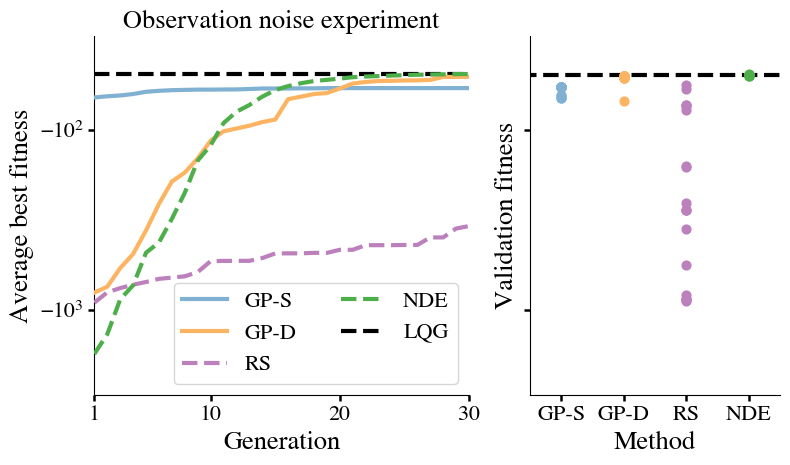

In [3]:
n_gen = 30
dynamic_fitness = jnp.zeros((20,n_gen))
rs_fitness = jnp.zeros((20,n_gen))
static_fitness = jnp.zeros((20,n_gen))
nde_fitness = jnp.zeros((20,n_gen))

for i in range(20):
    dynamic_fitness = dynamic_fitness.at[i].set(np.load(f'../results/harmonic_oscillator/single_env/GP/best_fitnesses_{i}.npy'))
    rs_fitness = rs_fitness.at[i].set(np.load(f'../results/harmonic_oscillator/single_env/RS/best_fitnesses_{i}.npy'))
    static_fitness = static_fitness.at[i].set(np.load(f'../results/harmonic_oscillator/single_env/FF/best_fitnesses_{i}.npy'))
    nde_fitness = nde_fitness.at[i].set(np.load(f'../results/harmonic_oscillator/single_env/ES/best_fitnesses_{i}.npy'))

LQG_fitness = np.load(f'../results/harmonic_oscillator/single_env/LQG/best_fitnesses.npy')

env = HarmonicOscillator(0.05, 0.3)
data = get_data(val_key, env, 32, 0.2, 50, "Constant")

f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 2]}, figsize=(8,4.75), sharey=True)

plot(-static_fitness, n_gen, label="GP-S", color=color_dict["static"], axis = a0, style='solid')
plot(-dynamic_fitness, n_gen, label="GP-D", color=color_dict["dynamic"], axis = a0, style='solid')
plot(-rs_fitness, n_gen, label="RS", color=color_dict["RS"], axis = a0, style='dashed')
plot(-nde_fitness, n_gen, label="NDE", color=color_dict["NDE"], axis = a0, style='dashed')
a0.hlines(-jnp.mean(LQG_fitness), 1, n_gen, label="LQG", color="black", linestyle='dashed', zorder=2, linewidth=3.0)

a0.spines[['right', 'top']].set_visible(False)

#Run the validation for the first time
# dynamic_val_fitness = jnp.zeros(20)
# static_val_fitness = jnp.zeros(20)
# nde_val_fitness = jnp.zeros(20)
# rs_val_fitness = jnp.zeros(20)

# for i in range(20):
#     dynamic_val_fitness = dynamic_val_fitness.at[i].set(validate_dynamic(np.load(f'../results/harmonic_oscillator/single_env/GP/best_solutions_{i}.npy')[-1], env, data, 2, 0.005))
#     static_val_fitness = static_val_fitness.at[i].set(validate_static(np.load(f'../results/harmonic_oscillator/single_env/FF/best_solutions_{i}.npy')[-1], env, data, 2, 0.005))
#     nde_val_fitness = nde_val_fitness.at[i].set(validate_NDE(np.load(f'../results/harmonic_oscillator/single_env/ES/best_solutions_{i}.npy')[-1], env, data, 5, 0.005))
#     rs_val_fitness = rs_val_fitness.at[i].set(validate_dynamic(np.load(f'../results/harmonic_oscillator/single_env/RS/best_solutions_{i}.npy')[-1], env, data, 2, 0.005))

# np.save(f'../results/validation_fitnesses/HO_FO_FF.npy',static_val_fitness)
# np.save(f'../results/validation_fitnesses/HO_FO_GP.npy',dynamic_val_fitness)
# np.save(f'../results/validation_fitnesses/HO_FO_RS.npy',rs_val_fitness)
# np.save(f'../results/validation_fitnesses/HO_FO_ES.npy',nde_val_fitness)

#Load the validation fitnesses
dynamic_val_fitness = np.load(f'../results/validation_fitnesses/HO_FO_GP.npy')
static_val_fitness = np.load(f'../results/validation_fitnesses/HO_FO_FF.npy')
nde_val_fitness = np.load(f'../results/validation_fitnesses/HO_FO_ES.npy')
rs_val_fitness = np.load(f'../results/validation_fitnesses/HO_FO_RS.npy')

for i in range(20):
    a1.scatter("GP-S", -static_val_fitness[i], color=color_dict["static"], s=40, zorder=1)
    a1.scatter("GP-D", -dynamic_val_fitness[i], color=color_dict["dynamic"], s=40, zorder=1)
    a1.scatter("RS", -rs_val_fitness[i], color=color_dict["RS"], s=40, zorder=1)
    a1.scatter("NDE", -nde_val_fitness[i], color=color_dict["NDE"], s=40, zorder=1)
a1.hlines(-validate_LQG(env, data, 0.005), -1, 4, label="LQG", color="black", linestyle='dashed', linewidth=3.0, zorder=0)

a0.legend(loc = 'lower right', fontsize=16, ncol=2)
a0.set(xlim=(1,30), ylim=(-3000,-30), yscale='symlog')
a1.set(xlim=(-0.5,3.5))
a0.set_xticks([1,10,20,30])
a0.set_xticklabels([1,10,20,30], fontsize=16)
a0.tick_params(axis='y', labelsize=16)
a0.set_title("Observation noise experiment", fontsize=19)
a0.set_xlabel("Generation", fontsize=19)
a0.set_ylabel("Average best fitness", fontsize=19)
a1.set_ylabel("Validation fitness", fontsize=19)
a1.set_xlabel("Method", fontsize=19)
a1.tick_params(axis='x', labelsize=16, labelrotation=0)
a0.tick_params(width=1.8, length=4.0, which='both')
a1.tick_params(width=1.8, length=4.0, which='both')
a1.spines[['right', 'top']].set_visible(False)

f.tight_layout()
plt.show()

## Experiment 2

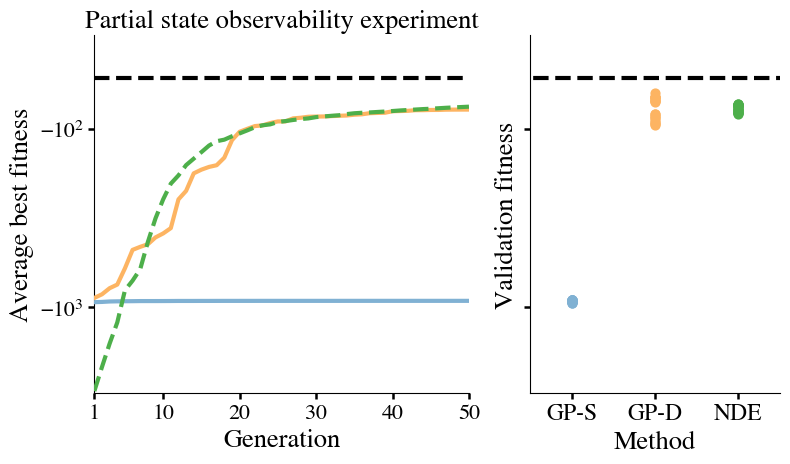

In [4]:
n_gen = 50
dynamic_fitness = jnp.zeros((20,n_gen))
static_fitness = jnp.zeros((20,n_gen))
nde_fitness = jnp.zeros((20,n_gen))

for i in range(20):
    dynamic_fitness = dynamic_fitness.at[i].set(np.load(f'../results/harmonic_oscillator/partial_obs/GP/best_fitnesses_{i}.npy'))
    static_fitness = static_fitness.at[i].set(np.load(f'../results/harmonic_oscillator/partial_obs/FF/best_fitnesses_{i}.npy'))
    nde_fitness = nde_fitness.at[i].set(np.load(f'../results/harmonic_oscillator/partial_obs/ES/best_fitnesses_{i}.npy'))

LQG_fitness = np.load(f'../results/harmonic_oscillator/partial_obs/LQG/best_fitnesses.npy')

env = HarmonicOscillator(0.05, 0.3, n_obs=1)
data = get_data(val_key, env, 32, 0.2, 50, "Constant")

f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 2]}, figsize=(8,4.75), sharey=True)
plot(-static_fitness, n_gen, label="GP-S", color=color_dict["static"], axis = a0, style='solid')
plot(-dynamic_fitness, n_gen, label="GP-D", color=color_dict["dynamic"], axis = a0, style='solid')
plot(-nde_fitness, n_gen, label="NDE", color=color_dict["NDE"], axis = a0, style='dashed')
a0.hlines(-jnp.mean(LQG_fitness), 1, n_gen, label="LQG", color="black", linestyle='dashed', linewidth=3.0, zorder=0)
a0.spines[['right', 'top']].set_visible(False)

#Run the validation for the first time
# dynamic_val_fitness = jnp.zeros(20)
# static_val_fitness = jnp.zeros(20)
# nde_val_fitness = jnp.zeros(20)

# for i in range(20):
#     dynamic_val_fitness = dynamic_val_fitness.at[i].set(validate_dynamic(np.load(f'../results/harmonic_oscillator/partial_obs/GP/best_solutions_{i}.npy')[-1], env, data, 2, 0.005))
#     static_val_fitness = static_val_fitness.at[i].set(validate_static(np.load(f'../results/harmonic_oscillator/partial_obs/FF/best_solutions_{i}.npy')[-1], env, data, 2, 0.005))
#     nde_val_fitness = nde_val_fitness.at[i].set(validate_NDE(np.load(f'../results/harmonic_oscillator/partial_obs/ES/best_solutions_{i}.npy')[-1], env, data, 5, 0.005))

# np.save(f'../results/validation_fitnesses/HO_PO_FF.npy',static_val_fitness)
# np.save(f'../results/validation_fitnesses/HO_PO_GP.npy',dynamic_val_fitness)
# np.save(f'../results/validation_fitnesses/HO_PO_ES.npy',nde_val_fitness)

#Load the validation fitnesses
dynamic_val_fitness = np.load(f'../results/validation_fitnesses/HO_PO_GP.npy')
static_val_fitness = np.load(f'../results/validation_fitnesses/HO_PO_FF.npy')
nde_val_fitness = np.load(f'../results/validation_fitnesses/HO_PO_ES.npy')

a1.hlines(-validate_LQG(env, data, 0.005), -1, 4, label="LQG", color="black", linestyle='dashed', linewidth=3.0, zorder=0)
for i in range(20):
    a1.scatter("GP-S", -static_val_fitness[i], color=color_dict["static"], s=40)
    a1.scatter("GP-D", -dynamic_val_fitness[i], color=color_dict["dynamic"], s=40)
    a1.scatter("NDE", -nde_val_fitness[i], color=color_dict["NDE"], s=40)

a0.set(xlim=(1,50), ylim=(-3000,-30), yscale='symlog')
a1.set(xlim=(-0.5,2.5))
a0.set_xticks([1,10,20,30,40,50])
a0.set_xticklabels([1,10,20,30,40,50], fontsize=16)
a0.tick_params(axis='y', labelsize=16)
a0.set_title("Partial state observability experiment", fontsize=19)
a0.set_xlabel("Generation", fontsize=19)
a0.set_ylabel("Average best fitness", fontsize=19)
a1.set_ylabel("Validation fitness", fontsize=19)
a1.set_xlabel("Method", fontsize=19)
a1.tick_params(axis='x', labelsize=17, labelrotation=0)
a0.tick_params(width=1.8, length=4.0, which='both')
a1.tick_params(width=1.8, length=4.0, which='both')
a1.spines[['right', 'top']].set_visible(False)

f.tight_layout()
plt.show()

## Comparison between lagged and dynamic policies

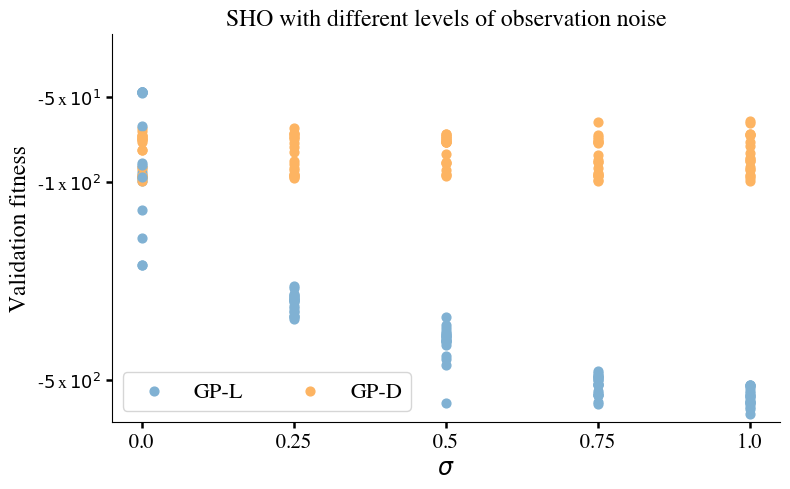

In [7]:
env = HarmonicOscillator(0.05, 0.0, n_obs=1)
data = get_data(val_key, env, 32, 0.02, 50, "Constant")

f, a0= plt.subplots(1, 1, figsize=(8,5))

#Run the validation for the first time
dsp0_val_fitness = jnp.zeros(20)
dsp2_val_fitness = jnp.zeros(20)
dsp5_val_fitness = jnp.zeros(20)
dsp7_val_fitness = jnp.zeros(20)
dsp1_val_fitness = jnp.zeros(20)

lag0_val_fitness = jnp.zeros(20)
lag2_val_fitness = jnp.zeros(20)
lag5_val_fitness = jnp.zeros(20)
lag7_val_fitness = jnp.zeros(20)
lag1_val_fitness = jnp.zeros(20)

for i in range(20):
    dsp0_val_fitness = dsp0_val_fitness.at[i].set(validate_dynamic_lax(np.load(f'../results/lag_comparison/GP/noise_0.0/best_solutions_{i}.npy')[-1], env, data, 2))
    lag0_val_fitness = lag0_val_fitness.at[i].set(validate_lag_static(np.load(f'../results/lag_comparison/LAG/noise_0.0/best_solutions_{i}.npy')[-1], env, data, 2))

    dsp2_val_fitness = dsp2_val_fitness.at[i].set(validate_dynamic_lax(np.load(f'../results/lag_comparison/GP/noise_0.25/best_solutions_{i}.npy')[-1], env, data, 2))
    lag2_val_fitness = lag2_val_fitness.at[i].set(validate_lag_static(np.load(f'../results/lag_comparison/LAG/noise_0.25/best_solutions_{i}.npy')[-1], env, data, 2))

    dsp5_val_fitness = dsp5_val_fitness.at[i].set(validate_dynamic_lax(np.load(f'../results/lag_comparison/GP/noise_0.5/best_solutions_{i}.npy')[-1], env, data, 2))
    lag5_val_fitness = lag5_val_fitness.at[i].set(validate_lag_static(np.load(f'../results/lag_comparison/LAG/noise_0.5/best_solutions_{i}.npy')[-1], env, data, 2))

    dsp7_val_fitness = dsp7_val_fitness.at[i].set(validate_dynamic_lax(np.load(f'../results/lag_comparison/GP/noise_0.75/best_solutions_{i}.npy')[-1], env, data, 2))
    lag7_val_fitness = lag7_val_fitness.at[i].set(validate_lag_static(np.load(f'../results/lag_comparison/LAG/noise_0.75/best_solutions_{i}.npy')[-1], env, data, 2))

    dsp1_val_fitness = dsp1_val_fitness.at[i].set(validate_dynamic_lax(np.load(f'../results/lag_comparison/GP/noise_1.0/best_solutions_{i}.npy')[-1], env, data, 2))
    lag1_val_fitness = lag1_val_fitness.at[i].set(validate_lag_static(np.load(f'../results/lag_comparison/LAG/noise_1.0/best_solutions_{i}.npy')[-1], env, data, 2))

# np.save(f'../results/validation_fitnesses/LAG_GP_0.0.npy',dsp0_val_fitness)
# np.save(f'../results/validation_fitnesses/LAG_GP_0.25.npy',dsp2_val_fitness)
# np.save(f'../results/validation_fitnesses/LAG_GP_0.5.npy',dsp5_val_fitness)
# np.save(f'../results/validation_fitnesses/LAG_GP_0.75.npy',dsp7_val_fitness)
# np.save(f'../results/validation_fitnesses/LAG_GP_1.0.npy',dsp1_val_fitness)

# np.save(f'../results/validation_fitnesses/LAG_FF_0.0.npy',lag0_val_fitness)
# np.save(f'../results/validation_fitnesses/LAG_FF_0.25.npy',lag2_val_fitness)
# np.save(f'../results/validation_fitnesses/LAG_FF_0.5.npy',lag5_val_fitness)
# np.save(f'../results/validation_fitnesses/LAG_FF_0.75.npy',lag7_val_fitness)
# np.save(f'../results/validation_fitnesses/LAG_FF_1.0.npy',lag1_val_fitness)

#Load the validation fitnesses
# dsp0_val_fitness = np.load(f'../results/validation_fitnesses/LAG_GP_0.0.npy')
# dsp2_val_fitness = np.load(f'../results/validation_fitnesses/LAG_GP_0.25.npy')
# dsp5_val_fitness = np.load(f'../results/validation_fitnesses/LAG_GP_0.5.npy')
# dsp7_val_fitness = np.load(f'../results/validation_fitnesses/LAG_GP_0.75.npy')
# dsp1_val_fitness = np.load(f'../results/validation_fitnesses/LAG_GP_1.0.npy')

# lag0_val_fitness = np.load(f'../results/validation_fitnesses/LAG_FF_0.0.npy')
# lag2_val_fitness = np.load(f'../results/validation_fitnesses/LAG_FF_0.25.npy')
# lag5_val_fitness = np.load(f'../results/validation_fitnesses/LAG_FF_0.5.npy')
# lag7_val_fitness = np.load(f'../results/validation_fitnesses/LAG_FF_0.75.npy')
# lag1_val_fitness = np.load(f'../results/validation_fitnesses/LAG_FF_1.0.npy')

for i in range(20):
    if i == 0:
        a0.scatter("0.0", -lag0_val_fitness[i], color=color_dict["static"], s=40, zorder=1, label="GP-L")
        a0.scatter("0.0", -dsp0_val_fitness[i], color=color_dict["dynamic"], s=40, zorder=1, label="GP-D")
    else:
        a0.scatter("0.0", -lag0_val_fitness[i], color=color_dict["static"], s=40, zorder=1)
        a0.scatter("0.0", -dsp0_val_fitness[i], color=color_dict["dynamic"], s=40, zorder=1)

    a0.scatter("0.25", -lag2_val_fitness[i], color=color_dict["static"], s=40, zorder=1)
    a0.scatter("0.25", -dsp2_val_fitness[i], color=color_dict["dynamic"], s=40, zorder=1)

    a0.scatter("0.5", -lag5_val_fitness[i], color=color_dict["static"], s=40, zorder=1)
    a0.scatter("0.5", -dsp5_val_fitness[i], color=color_dict["dynamic"], s=40, zorder=1)

    a0.scatter("0.75", -lag7_val_fitness[i], color=color_dict["static"], s=40, zorder=1)
    a0.scatter("0.75", -dsp7_val_fitness[i], color=color_dict["dynamic"], s=40, zorder=1)

    a0.scatter("1.0", -lag1_val_fitness[i], color=color_dict["static"], s=40, zorder=1)
    a0.scatter("1.0", -dsp1_val_fitness[i], color=color_dict["dynamic"], s=40, zorder=1)

a0.legend(loc = 'lower left', fontsize=16, ncol=2)
a0.set(ylim=(-700,-30), yscale='symlog')
a0.tick_params(axis='y', labelsize=16)
a0.set_yticks([-50, -100, -500])
a0.set_yticklabels(["-$5 \, $x$ \, 10^1$","-$1 \, $x$ \, 10^2$", "-$5 \, $x$ \, 10^2$"], fontsize=13)
a0.set_title("SHO with different levels of observation noise", fontsize=17)
a0.set_xlabel("$\sigma$", fontsize=17)
a0.set_ylabel("Validation fitness", fontsize=17)
a0.tick_params(width=1.8, length=4.0, which='both')
a0.tick_params(axis='x', labelsize=15, labelrotation=0)
a0.spines[['right', 'top']].set_visible(False)

f.tight_layout()
plt.show()

## Experiment 3

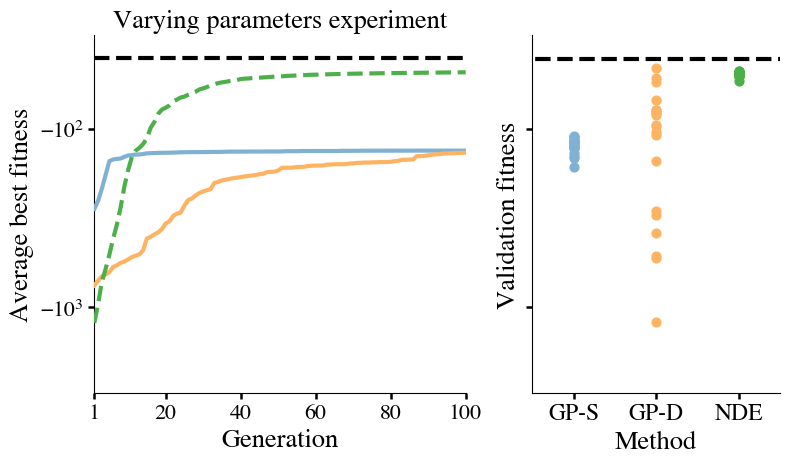

In [ ]:
n_gen = 100
dynamic_fitness = jnp.zeros((20,n_gen))
static_fitness = jnp.zeros((20,n_gen))
nde_fitness = jnp.zeros((20,n_gen))

for i in range(20):
    dynamic_fitness = dynamic_fitness.at[i].set(np.load(f'../results/harmonic_oscillator/multiple_env/GP/best_fitnesses_{i}.npy'))
    static_fitness = static_fitness.at[i].set(np.load(f'../results/harmonic_oscillator/multiple_env/FF/best_fitnesses_{i}.npy'))
    nde_fitness = nde_fitness.at[i].set(np.load(f'../results/harmonic_oscillator/multiple_env/ES/best_fitnesses_{i}.npy'))

LQG_fitness = np.load(f'../results/harmonic_oscillator/multiple_env/LQG/best_fitnesses.npy')

env = HarmonicOscillator(0.05, 0.3)
data = get_data(val_key, env, 32, 0.2, 50, "Different")
data2 = get_data(val_key, env, 32, 0.02, 50, "Different")

f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 2]}, figsize=(8,4.75), sharey=True)
plot(-static_fitness, n_gen, label="GP-S", color=color_dict["static"], axis = a0, style='solid')
plot(-dynamic_fitness, n_gen, label="GP-D", color=color_dict["dynamic"], axis = a0, style='solid')
plot(-nde_fitness, n_gen, label="NDE", color=color_dict["NDE"], axis = a0, style='dashed')

a0.hlines(-jnp.mean(LQG_fitness), 1, n_gen, label="LQG", color="black", linestyle='dashed', linewidth=3.0, zorder=0)
a0.spines[['right', 'top']].set_visible(False)

#Run the validation for the first time
# dynamic_val_fitness = jnp.zeros(20)
# static_val_fitness = jnp.zeros(20)
# nde_val_fitness = jnp.zeros(20)

# for i in range(20):
#     dynamic_val_fitness = dynamic_val_fitness.at[i].set(validate_dynamic(np.load(f'../results/harmonic_oscillator/multiple_env/GP/best_solutions_{i}.npy')[-1], env, data, 2, 0.005))
#     static_val_fitness = static_val_fitness.at[i].set(validate_static(np.load(f'../results/harmonic_oscillator/multiple_env/FF/best_solutions_{i}.npy')[-1], env, data, 2, 0.005))
#     nde_val_fitness = nde_val_fitness.at[i].set(validate_NDE(np.load(f'../results/harmonic_oscillator/multiple_env/ES/best_solutions_{i}.npy')[-1], env, data, 5, 0.005))

# np.save(f'../results/validation_fitnesses/HO_ME_FF.npy',static_val_fitness)
# np.save(f'../results/validation_fitnesses/HO_ME_GP.npy',dynamic_val_fitness)
# np.save(f'../results/validation_fitnesses/HO_ME_ES.npy',nde_val_fitness)

#Load the validation fitnesses
static_val_fitness = np.load(f'../results/validation_fitnesses/HO_ME_FF.npy')
dynamic_val_fitness = np.load(f'../results/validation_fitnesses/HO_ME_GP.npy')
nde_val_fitness = np.load(f'../results/validation_fitnesses/HO_ME_ES.npy')

a1.hlines(-validate_LQG(env, data, 0.005), -1, 4, label="LQG", color="black", linestyle='dashed', linewidth=3.0, zorder=0)
for i in range(20):
    a1.scatter("GP-S", -static_val_fitness[i], color=color_dict["static"], s=40)
    a1.scatter("GP-D", -dynamic_val_fitness[i], color=color_dict["dynamic"], s=40)
    a1.scatter("NDE", -nde_val_fitness[i], color=color_dict["NDE"], s=40)

a0.set(xlim=(1,100), ylim=(-3000,-30), yscale='symlog')
a1.set(xlim=(-0.5,2.5))
a0.set_xticks([1,20,40, 60,  80,  100])
a0.set_xticklabels([1,20,40, 60,  80,  100], fontsize=16)
a0.tick_params(axis='y', labelsize=16)
a0.set_title("Varying parameters experiment", fontsize=19)
a0.set_xlabel("Generation", fontsize=19)
a0.set_ylabel("Average best fitness", fontsize=19)
a1.set_ylabel("Validation fitness", fontsize=19)
a1.set_xlabel("Method", fontsize=19)
a1.tick_params(axis='x', labelsize=17, labelrotation=0)
a0.tick_params(width=1.8, length=4.0, which='both')
a1.tick_params(width=1.8, length=4.0, which='both')
a1.spines[['right', 'top']].set_visible(False)

f.tight_layout()
plt.show()

## Generalization analysis of experiment 3

/var/folders/zw/nv6_xj911gggvtc96kpndr_40000gp/T/ipykernel_11746/526067231.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Dark2')


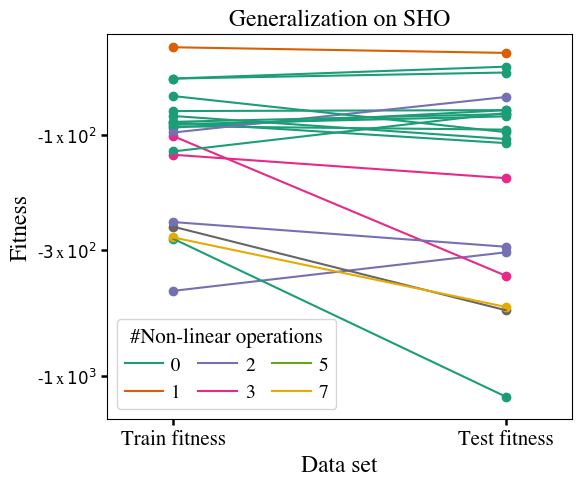

In [ ]:
n_gen = 100
dynamic_fitness = jnp.zeros((20,n_gen))

for i in range(20):
    dynamic_fitness = dynamic_fitness.at[i].set(np.load(f'../results/harmonic_oscillator/multiple_env/GP/best_fitnesses_{i}.npy'))

dynamic_val_fitness = np.load(f'../results/validation_fitnesses/HO_ME_GP.npy')

f, a0 = plt.subplots(1, 1, figsize=(6,5))
x_positions = jnp.arange(2)
colors = plt.cm.get_cmap('Dark2')
non_linear_operations = [0, 2, 0, 0, 0, 3, 3, 0, 0, 2, 0, 0, 0, 7, 0, 1, 0, 5, 0, 2] #Determined manually from the best solutions
index = 0
for i in range(np.min(non_linear_operations), np.max(non_linear_operations)+1):
    if i in non_linear_operations:
        plt.plot(0,0, label=f"{i}", color=colors(index))
        index +=1 
for i in range(20):
    plt.plot(x_positions, [-dynamic_fitness[i, -1], -dynamic_val_fitness[i]], color=colors(non_linear_operations[i]))
    plt.scatter(x_positions, [-dynamic_fitness[i, -1], -dynamic_val_fitness[i]], color=colors(non_linear_operations[i]))

a0.set_title("Generalization on SHO", fontsize=17)
a0.set_xlabel("Data set", fontsize=17)
a0.set_ylabel("Fitness", fontsize=17)
a0.tick_params(axis='y', labelsize=15)
a0.set(ylim=(-1500,-38), yscale='symlog')
a0.set_yticks([-100, -300, -1000])
a0.set_yticklabels(["-$1 \, $x$ \, 10^2$","-$3 \, $x$ \, 10^2$", "-$1 \, $x$ \, 10^3$"], fontsize=12)
a0.tick_params(width=1.8, length=4.0, which='both')
a0.set_xticks(x_positions)
a0.set_xticklabels(["Train fitness", "Test fitness"], fontsize=15)
a0.set_xlim(x_positions[0] - 0.2, x_positions[-1] + 0.2)
a0.legend(loc="lower left", ncol=3, title="#Non-linear operations", fontsize=14, title_fontsize=15, columnspacing=0.9, handletextpad=0.4)
plt.show()

## Experiment 4

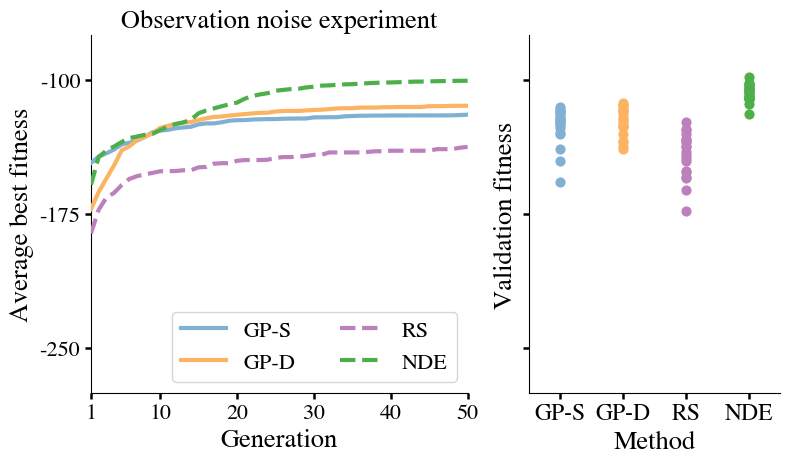

In [ ]:
n_gen = 50
dynamic_fitness = jnp.zeros((20,n_gen))
static_fitness = jnp.zeros((20,n_gen))
rs_fitness = jnp.zeros((20,n_gen))
nde_fitness = jnp.zeros((20,n_gen))

for i in range(20):
    dynamic_fitness = dynamic_fitness.at[i].set(np.load(f'../results/acrobot/single_env/GP/best_fitnesses_{i}.npy'))
    rs_fitness = rs_fitness.at[i].set(np.load(f'../results/acrobot/single_env/RS/best_fitnesses_{i}.npy'))
    static_fitness = static_fitness.at[i].set(np.load(f'../results/acrobot/single_env/FF/best_fitnesses_{i}.npy'))
    nde_fitness = nde_fitness.at[i].set(np.load(f'../results/acrobot/single_env/ES/best_fitnesses_{i}.npy'))

env = Acrobot(0.05, 0.3)
data = get_data(val_key, env, 32, 0.2, 50, "Constant")

f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 2]}, figsize=(8,4.75), sharey=True)
plot(-static_fitness, n_gen, label="GP-S", color=color_dict["static"], axis = a0, style='solid')
plot(-dynamic_fitness, n_gen, label="GP-D", color=color_dict["dynamic"], axis = a0, style='solid')
plot(-rs_fitness, n_gen, label="RS", color=color_dict["RS"], axis = a0, style='dashed')
plot(-nde_fitness, n_gen, label="NDE", color=color_dict["NDE"], axis = a0, style='dashed')
a0.spines[['right', 'top']].set_visible(False)

#Run the validation for the first time
# dynamic_val_fitness = jnp.zeros(20)
# static_val_fitness = jnp.zeros(20)
# nde_val_fitness = jnp.zeros(20)
# rs_val_fitness = jnp.zeros(20)

# for i in range(20):
#     dynamic_val_fitness = dynamic_val_fitness.at[i].set(validate_dynamic(np.load(f'../results/acrobot/single_env/GP/best_solutions_{i}.npy')[-1], env, data, 2, 0.005, ["sin", "cos"]))
#     static_val_fitness = static_val_fitness.at[i].set(validate_static(np.load(f'../results/acrobot/single_env/FF/best_solutions_{i}.npy')[-1], env, data, 2, 0.005, ["sin", "cos"]))
#     nde_val_fitness = nde_val_fitness.at[i].set(validate_NDE(np.load(f'../results/acrobot/single_env/ES/best_solutions_{i}.npy')[-1], env, data, 5, 0.005))
#     rs_val_fitness = rs_val_fitness.at[i].set(validate_dynamic(np.load(f'../results/acrobot/single_env/RS/best_solutions_{i}.npy')[-1], env, data, 2, 0.005, ["sin", "cos"]))

# np.save(f'../results/validation_fitnesses/AC_FO_FF.npy',static_val_fitness)
# np.save(f'../results/validation_fitnesses/AC_FO_GP.npy',dynamic_val_fitness)
# np.save(f'../results/validation_fitnesses/AC_FO_RS.npy',rs_val_fitness)
# np.save(f'../results/validation_fitnesses/AC_FO_ES.npy',nde_val_fitness)

#Load the validation fitnesses
dynamic_val_fitness = np.load(f'../results/validation_fitnesses/AC_FO_GP.npy')
static_val_fitness = np.load(f'../results/validation_fitnesses/AC_FO_FF.npy')
nde_val_fitness = np.load(f'../results/validation_fitnesses/AC_FO_ES.npy')
rs_val_fitness = np.load(f'../results/validation_fitnesses/AC_FO_RS.npy')

for i in range(20):
    a1.scatter("GP-S", -static_val_fitness[i], color=color_dict["static"], s=40)
    a1.scatter("GP-D", -dynamic_val_fitness[i], color=color_dict["dynamic"], s=40)
    a1.scatter("RS", -rs_val_fitness[i], color=color_dict["RS"], s=40)
    a1.scatter("NDE", -nde_val_fitness[i], color=color_dict["NDE"], s=40)

a0.legend(loc = 'lower right', fontsize=16, ncol=2)
a0.set(xlim=(1,50), ylim=(-275,-75))
a1.set(xlim=(-0.5,3.5))
a0.set_xticks([1,10,20,30,40,50])
a0.set_xticklabels([1,10,20,30,40,50], fontsize=16)
a0.set_yticks([-100,-175,-250])
a0.set_yticklabels([-100,-175,-250], fontsize=16)
a0.tick_params(axis='y', labelsize=16)
a0.set_title("Observation noise experiment", fontsize=19)
a0.set_xlabel("Generation", fontsize=19)
a0.set_ylabel("Average best fitness", fontsize=19)
a1.set_ylabel("Validation fitness", fontsize=19)
a1.set_xlabel("Method", fontsize=19)
a1.tick_params(axis='x', labelsize=17, labelrotation=0)
a0.tick_params(width=1.8, length=4.0, which='both')
a1.tick_params(width=1.8, length=4.0, which='both')
a1.spines[['right', 'top']].set_visible(False)

f.tight_layout()
plt.show()

## Experiment 5

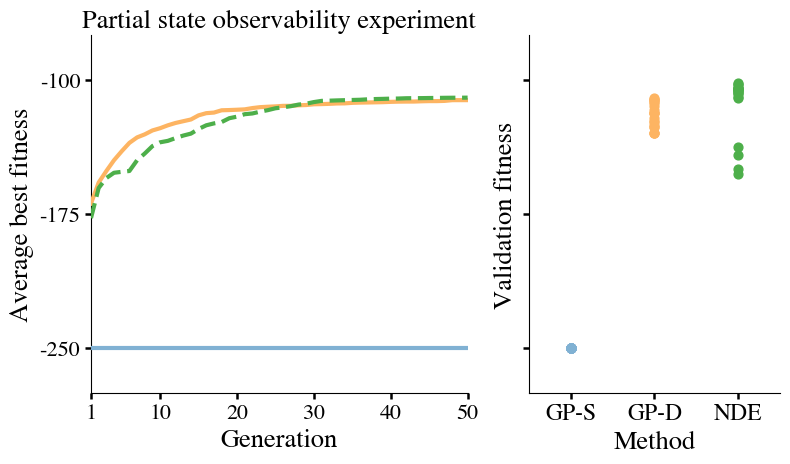

In [ ]:
n_gen = 50
dynamic_fitness = jnp.zeros((20,n_gen))
static_fitness = jnp.zeros((20,n_gen))
nde_fitness = jnp.zeros((20,n_gen))

for i in range(20):
    dynamic_fitness = dynamic_fitness.at[i].set(np.load(f'../results/acrobot/partial_obs/GP/best_fitnesses_{i}.npy'))
    static_fitness = static_fitness.at[i].set(np.load(f'../results/acrobot/partial_obs/FF/best_fitnesses_{i}.npy'))
    nde_fitness = nde_fitness.at[i].set(np.load(f'../results/acrobot/partial_obs/ES/best_fitnesses_{i}.npy'))

env = Acrobot(0.05, 0.3, n_obs=2)
data = get_data(val_key, env, 32, 0.2, 50, "Constant")

f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 2]}, figsize=(8,4.75), sharey=True)
plot(-static_fitness, n_gen, label="GP-S", color=color_dict["static"], axis = a0, style='solid')
plot(-dynamic_fitness, n_gen, label="GP-D", color=color_dict["dynamic"], axis = a0, style='solid')
plot(-nde_fitness, n_gen, label="NDE", color=color_dict["NDE"], axis = a0, style='dashed')
a0.spines[['right', 'top']].set_visible(False)

#Run the validation for the first time
# dynamic_val_fitness = jnp.zeros(20)
# static_val_fitness = jnp.zeros(20)
# nde_val_fitness = jnp.zeros(20)

# for i in range(20):
#     dynamic_val_fitness = dynamic_val_fitness.at[i].set(validate_dynamic(np.load(f'../results/acrobot/partial_obs/GP/best_solutions_{i}.npy')[-1], env, data, 2, 0.005, ["sin", "cos"]))
#     static_val_fitness = static_val_fitness.at[i].set(validate_static(np.load(f'../results/acrobot/partial_obs/FF/best_solutions_{i}.npy')[-1], env, data, 2, 0.005, ["sin", "cos"]))
#     nde_val_fitness = nde_val_fitness.at[i].set(validate_NDE(np.load(f'../results/acrobot/partial_obs/ES/best_solutions_{i}.npy')[-1], env, data, 5, 0.005))

# np.save(f'../results/validation_fitnesses/AC_PO_FF.npy',static_val_fitness)
# np.save(f'../results/validation_fitnesses/AC_PO_GP.npy',dynamic_val_fitness)
# np.save(f'../results/validation_fitnesses/AC_PO_ES.npy',nde_val_fitness)

#Load the validation fitnesses
dynamic_val_fitness = np.load(f'../results/validation_fitnesses/AC_PO_GP.npy')
static_val_fitness = np.load(f'../results/validation_fitnesses/AC_PO_FF.npy')
nde_val_fitness = np.load(f'../results/validation_fitnesses/AC_PO_ES.npy')

for i in range(20):
    a1.scatter("GP-S", -static_val_fitness[i], color=color_dict["static"], s=40)
    a1.scatter("GP-D", -dynamic_val_fitness[i], color=color_dict["dynamic"], s=40)
    a1.scatter("NDE", -nde_val_fitness[i], color=color_dict["NDE"], s=40)

a0.set(xlim=(1,50), ylim=(-275,-75))
a1.set(xlim=(-0.5,2.5))
a0.set_xticks([1,10,20,30,40,50])
a0.set_xticklabels([1,10,20,30,40,50], fontsize=16)
a0.set_yticks([-100,-175,-250])
a0.set_yticklabels([-100,-175,-250], fontsize=16)
a0.tick_params(axis='y', labelsize=16)
a0.set_title("Partial state observability experiment", fontsize=19)
a0.set_xlabel("Generation", fontsize=19)
a0.set_ylabel("Average best fitness", fontsize=19)
a1.set_ylabel("Validation fitness", fontsize=19)
a1.set_xlabel("Method", fontsize=19)
a1.tick_params(axis='x', labelsize=17, labelrotation=0)
a0.tick_params(width=1.8, length=4.0, which='both')
a1.tick_params(width=1.8, length=4.0, which='both')
a1.spines[['right', 'top']].set_visible(False)

f.tight_layout()
plt.show()

## Experiment 6

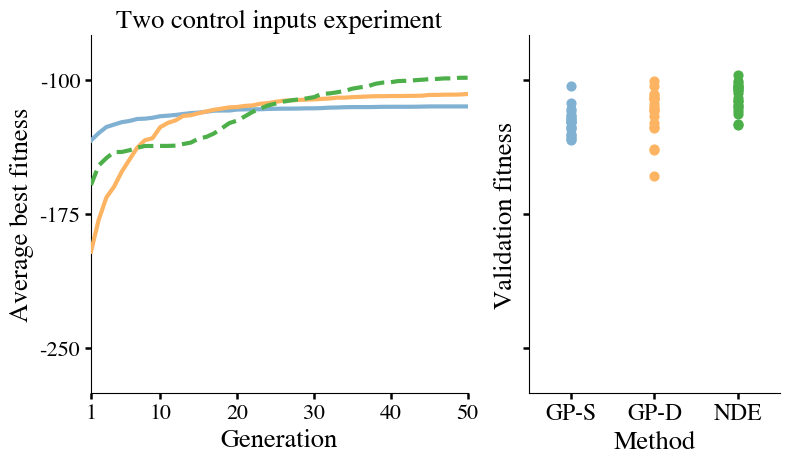

In [ ]:
n_gen = 50
dynamic_fitness = jnp.zeros((20,n_gen))
static_fitness = jnp.zeros((20,n_gen))
nde_fitness = jnp.zeros((20,n_gen))

for i in range(20):
    dynamic_fitness = dynamic_fitness.at[i].set(np.load(f'../results/acrobot/two_control/GP/best_fitnesses_{i}.npy')[:50])
    static_fitness = static_fitness.at[i].set(np.load(f'../results/acrobot/two_control/FF/best_fitnesses_{i}.npy'))
    nde_fitness = nde_fitness.at[i].set(np.load(f'../results/acrobot/two_control/ES/best_fitnesses_{i}.npy'))

env = Acrobot2(0.05, 0.3)
data = get_data(val_key, env, 32, 0.2, 50, "Constant")

f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 2]}, figsize=(8,4.75), sharey=True)
plot(-static_fitness, n_gen, label="GP-S", color=color_dict["static"], axis = a0, style='solid')
plot(-dynamic_fitness, n_gen, label="GP-D", color=color_dict["dynamic"], axis = a0, style='solid')
plot(-nde_fitness, n_gen, label="NDE", color=color_dict["NDE"], axis = a0, style='dashed')
a0.spines[['right', 'top']].set_visible(False)

#Run the validation for the first time
# dynamic_val_fitness = jnp.zeros(20)
# static_val_fitness = jnp.zeros(20)
# nde_val_fitness = jnp.zeros(20)

# for i in range(20):
#     dynamic_val_fitness = dynamic_val_fitness.at[i].set(validate_dynamic(np.load(f'../results/acrobot/two_control/GP/best_solutions_{i}.npy')[-1], env, data, 3, 0.005, ["sin", "cos"]))
#     static_val_fitness = static_val_fitness.at[i].set(validate_static(np.load(f'../results/acrobot/two_control/FF/best_solutions_{i}.npy')[-1], env, data, 3, 0.005, ["sin", "cos"]))
#     nde_val_fitness = nde_val_fitness.at[i].set(validate_NDE(np.load(f'../results/acrobot/two_control/ES/best_solutions_{i}.npy')[-1], env, data, 5, 0.005))

# np.save(f'../results/validation_fitnesses/AC_DC_FF.npy',static_val_fitness)
# np.save(f'../results/validation_fitnesses/AC_DC_GP.npy',dynamic_val_fitness)
# np.save(f'../results/validation_fitnesses/AC_DC_ES.npy',nde_val_fitness)

#Load the validation fitnesses
static_val_fitness = np.load(f'../results/validation_fitnesses/AC_DC_FF.npy')
dynamic_val_fitness = np.load(f'../results/validation_fitnesses/AC_DC_GP.npy')
nde_val_fitness = np.load(f'../results/validation_fitnesses/AC_DC_ES.npy')

for i in range(20):
    a1.scatter("GP-S", -static_val_fitness[i], color=color_dict["static"], s=40)
    a1.scatter("GP-D", -dynamic_val_fitness[i], color=color_dict["dynamic"], s=40)
    a1.scatter("NDE", -nde_val_fitness[i], color=color_dict["NDE"], s=40)

a0.set(xlim=(1,50), ylim=(-275,-75))
a1.set(xlim=(-0.5,2.5))
a0.set_xticks([1,10,20,30,40,50])
a0.set_xticklabels([1,10,20,30,40,50], fontsize=16)
a0.set_yticks([-100,-175,-250])
a0.set_yticklabels([-100,-175,-250], fontsize=16)
a0.tick_params(axis='y', labelsize=16)
a0.set_title("Two control inputs experiment", fontsize=19)
a0.set_xlabel("Generation", fontsize=19)
a0.set_ylabel("Average best fitness", fontsize=19)
a1.set_ylabel("Validation fitness", fontsize=19)
a1.set_xlabel("Method", fontsize=19)
a1.tick_params(axis='x', labelsize=17, labelrotation=0)
a0.tick_params(width=1.8, length=4.0, which='both')
a1.tick_params(width=1.8, length=4.0, which='both')
a1.spines[['right', 'top']].set_visible(False)

f.tight_layout()

plt.show()

## Experiment 7

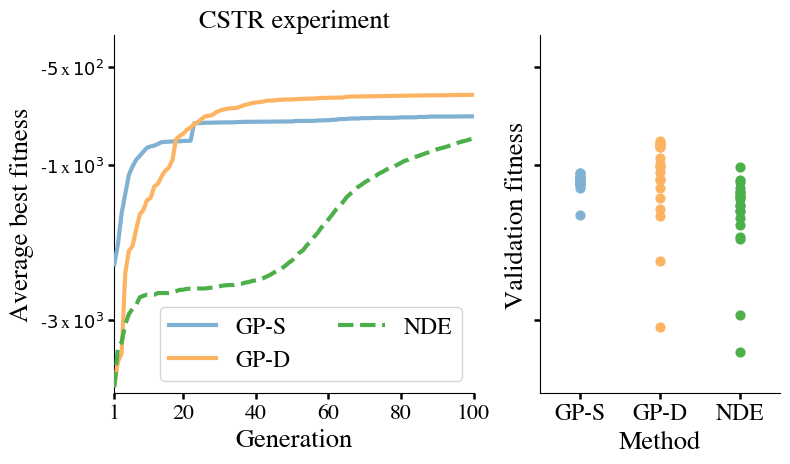

In [ ]:
n_gen = 100
indices = np.array([0,1,2,3,4,5,6,7,10,11,12,13,14,15,16,17,18,19, 20, 23])
dynamic_fitness = jnp.zeros((20,n_gen))
static_fitness = jnp.zeros((20,n_gen))
nde_fitness = jnp.zeros((20,n_gen))

for i in range(20):
    index = indices[i]
    dynamic_fitness = dynamic_fitness.at[i].set(np.load(f'../results/reactor/GP/best_fitnesses_{index}.npy'))
    static_fitness = static_fitness.at[i].set(np.load(f'../results/reactor/FF/best_fitnesses_{index}.npy'))
    nde_fitness = nde_fitness.at[i].set(np.load(f'../results/reactor/ES/best_fitnesses_{index}.npy'))

env = StirredTankReactor(0.5, 0.5, n_obs=2)
data = get_data(jrandom.PRNGKey(102), env, 32, 0.1, 50, "Different")

f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 2]}, figsize=(8,4.75), sharey=True)
plot(-static_fitness, n_gen, label="GP-S", color=color_dict["static"], axis = a0, style='solid')
plot(-dynamic_fitness, n_gen, label="GP-D", color=color_dict["dynamic"], axis = a0, style='solid')
plot(-nde_fitness, n_gen, label="NDE", color=color_dict["NDE"], axis = a0, style='dashed')
a0.spines[['right', 'top']].set_visible(False)

#Run the validation for the first time
# dynamic_val_fitness = jnp.zeros(20)
# static_val_fitness = jnp.zeros(20)
# nde_val_fitness = jnp.zeros(20)

# for i in range(20):
#     index = indices[i]
#     dynamic_val_fitness = dynamic_val_fitness.at[i].set(validate_dynamic(np.load(f'../results/reactor/GP/best_solutions_{index}.npy')[-1], env, data, 2, 0.0002, ["exp", "log"]))
#     static_val_fitness = static_val_fitness.at[i].set(validate_static(np.load(f'../results/reactor/FF/best_solutions_{index}.npy')[-1], env, data, 2, 0.0002, ["exp", "log"]))
#     nde_val_fitness = nde_val_fitness.at[i].set(validate_NDE(np.load(f'../results/reactor/ES/best_solutions_{index}.npy')[-1], env, data, 5, 0.0002, ))

# np.save(f'../results/validation_fitnesses/CSTR_FF.npy',static_val_fitness)
# np.save(f'../results/validation_fitnesses/CSTR_GP.npy',dynamic_val_fitness)
# np.save(f'../results/validation_fitnesses/CSTR_ES.npy',nde_val_fitness)

#Load the validation fitnesses
dynamic_val_fitness = np.load(f'../results/validation_fitnesses/CSTR_GP.npy')
static_val_fitness = np.load(f'../results/validation_fitnesses/CSTR_FF.npy')
nde_val_fitness = np.load(f'../results/validation_fitnesses/CSTR_ES.npy')

for i in range(20):
    a1.scatter("GP-S", -static_val_fitness[i], color=color_dict["static"], s=40)
    a1.scatter("GP-D", -dynamic_val_fitness[i], color=color_dict["dynamic"], s=40)
    a1.scatter("NDE", -nde_val_fitness[i], color=color_dict["NDE"], s=40)

a1.spines[['right', 'top']].set_visible(False)
a0.legend(loc = 'lower right', fontsize=17, ncol=2)
a1.set(xlim=(-0.5,2.5))
a0.set(xlim=(1,100), yscale='symlog', ylim=(-5000, -400))
a0.set_xticks([1,20,40,60,80,100])
a0.set_xticklabels([1,20,40,60,80,100], fontsize=16)
a0.set_yticks([-500, -1000, -3000])
a0.set_yticklabels(["-$5 \, $x$ \, 10^2$","-$1 \, $x$ \, 10^3$", "-$3 \, $x$ \, 10^3$"], fontsize=16)
a0.tick_params(axis='y', labelsize=13)
a0.set_title("CSTR experiment", fontsize=19)
a0.set_xlabel("Generation", fontsize=19)
a0.set_ylabel("Average best fitness", fontsize=19)
a1.set_ylabel("Validation fitness", fontsize=19)
a1.set_xlabel("Method", fontsize=19)
a1.tick_params(axis='x', labelsize=17, labelrotation=0)
a0.tick_params(width=1.8, length=4.0, which='both')
a1.tick_params(width=1.8, length=4.0, which='both')

f.tight_layout()

plt.show()

## Generalization analysis of experiment 7

/var/folders/zw/nv6_xj911gggvtc96kpndr_40000gp/T/ipykernel_11746/3113356539.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Dark2')


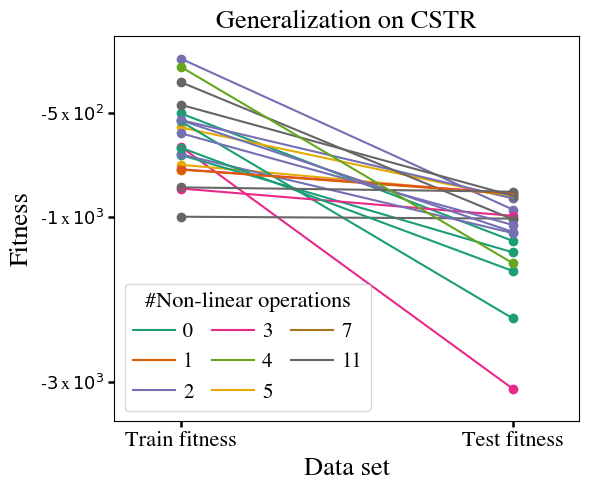

In [ ]:
n_gen = 100
indices = np.array([0,1,2,3,4,5,6,7,10,11,12,13,14,15,16,17,18,19, 20, 23])
dynamic_fitness = jnp.zeros((20,n_gen))
static_fitness = jnp.zeros((20,n_gen))
nde_fitness = jnp.zeros((20,n_gen))

for i in range(20):
    index = indices[i]
    dynamic_fitness = dynamic_fitness.at[i].set(np.load(f'../results/reactor/GP/best_fitnesses_{index}.npy'))

dynamic_val_fitness = np.load(f'../results/validation_fitnesses/CSTR_GP.npy')

f, a0 = plt.subplots(1, 1, figsize=(6,5))
x_positions = jnp.arange(2)
colors = plt.cm.get_cmap('Dark2')
non_linear_operations = [0, 2, 3, 5, 2, 5, 0, 3, 0, 3, 7, 2, 0, 11, 1, 2, 2, 11, 11, 4]
index = 0
for i in range(np.min(non_linear_operations), np.max(non_linear_operations)+1):
    if i in non_linear_operations:
        plt.plot(0,0, label=f"{i}", color=colors(index))
        index += 1
for i in range(20):
    plt.plot(x_positions, [-dynamic_fitness[i, -1], -dynamic_val_fitness[i]], color=colors(non_linear_operations[i]))
    plt.scatter(x_positions, [-dynamic_fitness[i, -1], -dynamic_val_fitness[i]], color=colors(non_linear_operations[i]))
a0.set_title("Generalization on CSTR", fontsize=19)
a0.set_xlabel("Data set", fontsize=19)
a0.set_ylabel("Fitness", fontsize=19)
a0.set(ylim=(-3900,-300), yscale='symlog')
a0.tick_params(axis='y', labelsize=16)
a0.tick_params(width=1.8, length=4.0, which='both')
a0.set_xticks(x_positions)
a0.set_yticks([-500, -1000, -3000])
a0.set_yticklabels(["-$5 \, $x$ \, 10^2$","-$1 \, $x$ \, 10^3$", "-$3 \, $x$ \, 10^3$"], fontsize=13)
a0.set_xticklabels(["Train fitness", "Test fitness"], fontsize=16)
a0.set_xlim(x_positions[0] - 0.2, x_positions[-1] + 0.2)
a0.legend(loc="lower left", ncol=3, title="#Non-linear operations", fontsize=15, title_fontsize=16, columnspacing=0.9, handletextpad=0.4)
plt.show()

## CSTR Simulations

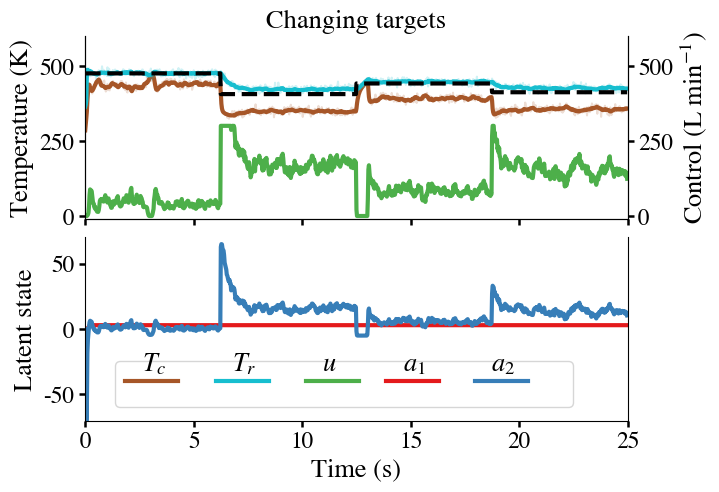

In [ ]:
def evaluate_policy(env, data, model_string):
    model = parse_model(model_string)
    
    layer_expressions = [Expression(obs_size=env.n_obs, state_size=2, control_size=env.n_control, target_size=env.n_targets, unary_functions= ["exp", "log"]), 
                            Expression(obs_size=0, state_size=2, control_size=0, target_size=env.n_targets, unary_functions= ["exp", "log"],
                                condition=lambda self, tree: sum([leaf in self.state_variables for leaf in jax.tree_util.tree_leaves(tree)])==0)]
    fitness_function = dynamic_evaluate.Evaluator(env, 2, 0.0002)

    return fitness_function.evaluate_model(model.tree_to_function(layer_expressions), data)

def plot_reactor(env, data, model_string, title, batch_index=0):
    plt.rcParams["mathtext.fontset"] = 'stix'
    x0s, ts, targets, keys1, keys2, params = data
    dxs, dys, dus, activities, dfitness = evaluate_policy(env, data, model_string)

    figure, ax = plt.subplots(2, 1, figsize=(7,5), sharex=True, sharey=False)
    labels = ["T_c", "T_r"]
   
    moving_targets = jax.vmap(lambda tar: jnp.hstack([t*jnp.ones(int(ts.shape[0]//targets.shape[1])) for t in tar]))(targets)[batch_index]

    colormap2 = cm.Set1

    width = 3.0
    ax[1].plot(0, 0, color = colormap2(0.7), label = f"${labels[0]}$", linewidth = width)
    ax[1].plot(0, 0, color = cm.tab10(0.99), label = f"${labels[1]}$", linewidth = width)

    ax[0].plot(ts, dxs[batch_index,:,0], color = colormap2(0.7), label = f"${labels[0]}$", linewidth = width)
    ax[0].plot(ts, dys[batch_index,:,0], color = colormap2(0.7), alpha = 0.2)

    ax[0].plot(ts, dxs[batch_index,:,1], color = cm.tab10(0.99), label = f"${labels[1]}$", linewidth = width)
    ax[0].plot(ts, dys[batch_index,:,1], color = cm.tab10(0.99), alpha = 0.2)
   
    ax[0].plot(ts, jnp.clip(dus[batch_index,:,0], 0, 300), color = colormap2(0.3), label = f"$u$", linewidth = width)
    ax[1].plot(0, 0, color = colormap2(0.3), label = f"$u$", linewidth = width)
    ax[0].plot(ts, moving_targets, linestyle='dashed', color = "black", linewidth = width)

    for j in range(2):
        ax[1].plot(ts, activities[batch_index,:,j], color = colormap2(0.1*(j+1)), label = f"$a_{j+1}$", linewidth = width)

    for a in ax.ravel():
        a.set(xlim=(0,ts[-1]))
        a.tick_params(axis='y', labelsize=17)
        a.tick_params(width=1.8, length=4.0, which='both')
        a.spines[['top']].set_visible(False)

    ax[0].set_title(title, fontsize=19)
    ax[0].set(ylim=(-10,600))
    ax[1].set(ylim=(-70,70))
    ax[1].set_xticks([0,5,10,15,20,25])
    ax[1].set_xticklabels([0,5,10,15,20,25], fontsize=17)
    ax[1].tick_params(axis='x', labelsize=17)
    ax[1].set_xlabel("Time (s)", fontsize=19)

    ax[0].set_ylabel("Temperature (K)", fontsize=19)
    ax[1].set_ylabel("Latent state", fontsize=19)

    ax[1].set_yticks([-50,0,50])
    ax[0].set_yticks([0,250,500])
    ax[0].set_yticklabels([0,250,500], fontsize=17)
    ax[1].set_yticklabels([-50,0,50], fontsize=17)

    ax2 = ax[0].twinx()
    ax2.set_ylabel("Control (L min$^{-1}$)", fontsize=19)

    ax2.tick_params(axis='y', labelsize=17)
    ax2.tick_params(width=1.8, length=4.0, which='both')
    ax2.spines[['top']].set_visible(False)
    ax2.set_yticks([0,250,500])
    ax2.set_yticklabels([0,250,500], fontsize=17)
    ax2.set(ylim=(-10,600))

    legend1 = ax[1].legend(ncol=5, fontsize=19, bbox_to_anchor=(0.03, 0.4), frameon=True, columnspacing=0.1, handletextpad=0.4)
    
    # Update the legend font properties
    for text in legend1.get_texts():
        text.set_fontfamily('times')

    for txt in legend1.get_texts():
        txt.set_ha("center") # horizontal alignment of text item
        txt.set_x(-47) # x-position
        txt.set_y(20) # y-position

    plt.subplots_adjust(wspace=0.0, hspace=0.1)
    plt.show()

max_control = jnp.array([300])
env = StirredTankReactor(0.5, 0.5, n_targets=4, n_obs=2, max_target=480)
plot_key = jrandom.PRNGKey(143)
reactor_data = get_data(plot_key, env, 1, 0.025, 25, "Different")

model_string = np.load(f'../results/reactor/GP/best_solutions_20.npy')[-1]
ax0 = plot_reactor(env, reactor_data, model_string, "Changing targets")

The legend has been placed in a correct position manually.

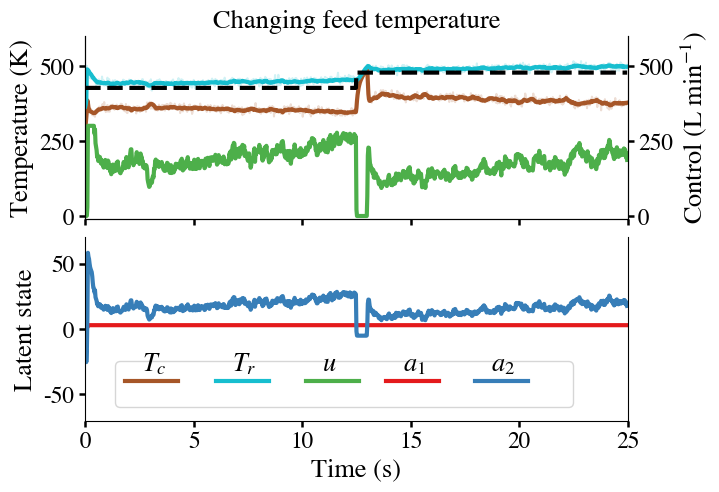

In [ ]:
env = StirredTankReactor(0.5, 0.5, n_targets=2, n_obs=2, max_target=480)
plot_key = jrandom.PRNGKey(143)
reactor_data = get_data(plot_key, env, 1, 0.025, 25, "Changing")
ax0 = plot_reactor(env, reactor_data, model_string, "Changing feed temperature")

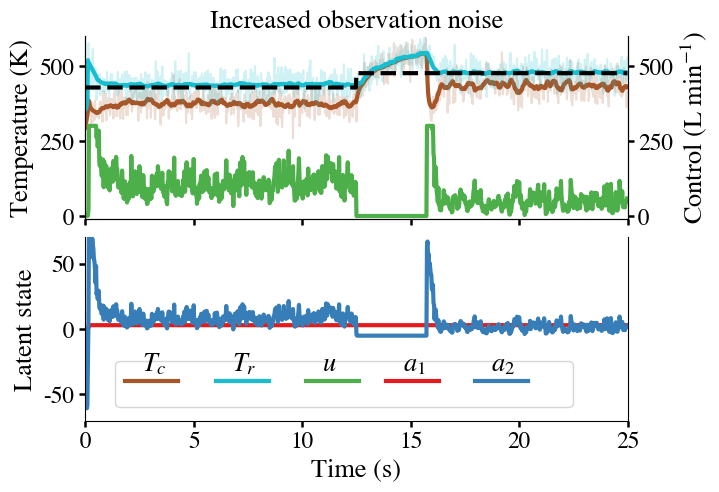

In [ ]:
env = StirredTankReactor(0.5, 2.0, n_targets=2, n_obs=2, max_target=480)
plot_key = jrandom.PRNGKey(145)
reactor_data = get_data(plot_key, env, 1, 0.025, 25, "Different")

ax0 = plot_reactor(env, reactor_data, model_string, "Increased observation noise")

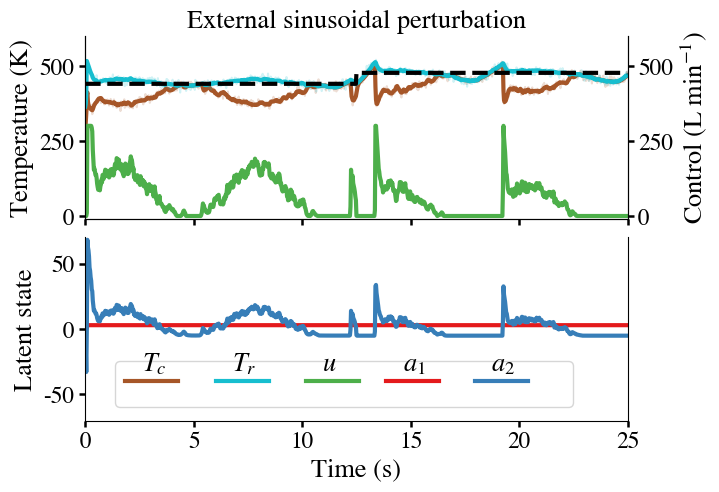

In [ ]:
env = StirredTankReactor(0.5, 0.5, n_targets=2, n_obs=2, external_f=lambda t: 100*jnp.sin(t), max_target=480)
plot_key = jrandom.PRNGKey(146)
reactor_data = get_data(plot_key, env, 1, 0.025, 25, "Different")

ax0 = plot_reactor(env, reactor_data, model_string, "External sinusoidal perturbation")